# Evaluación de Modelos - Alke Wallet

Este notebook se enfoca en la evaluación final del modelo seleccionado para el proyecto de evaluación crediticia automática de Alke Wallet.

## Objetivo

- Evaluar el rendimiento del modelo final
- Analizar en detalle las predicciones correctas e incorrectas
- Identificar posibles sesgos o debilidades del modelo
- Preparar el modelo para su despliegue en la API

## 1. Importación de Bibliotecas

In [1]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.calibration import calibration_curve

# Para cargar modelos
import joblib
import os

# Importar módulos personalizados
import sys
sys.path.append('..')
from src.evaluation import evaluate_classification_model, plot_roc_curve

# Configuración para visualizaciones
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set(style='whitegrid')

C:\Users\etien\AppData\Local\Temp\ipykernel_14948\4169799416.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 2. Carga de Datos y Modelo

In [2]:
# Cargar los datos preprocesados
try:
    X_test_processed = np.load('../data/X_test_processed.npy')
    y_test = np.load('../data/y_test.npy')
    feature_names = np.load('../models/feature_names.npy')
    
    # También cargar las versiones originales para análisis
    X_test_original = pd.read_csv('../data/X_test.csv')
    
    print(f"X_test_processed shape: {X_test_processed.shape}")
    print(f"y_test shape: {y_test.shape}")
    print(f"Número de características: {len(feature_names)}")
except FileNotFoundError:
    print("No se encontraron los datos preprocesados. Por favor, ejecute primero los notebooks de preprocesamiento y entrenamiento.")

X_test_processed shape: (200, 13)
y_test shape: (200,)
Número de características: 13


In [3]:
# Cargar el mejor modelo
try:
    best_model = joblib.load('../models/credit_model.joblib')
    print(f"Modelo cargado: {type(best_model).__name__}")
    
    # Cargar también el preprocesador para ejemplos nuevos
    preprocessor = joblib.load('../models/preprocessor.joblib')
    print(f"Preprocesador cargado: {type(preprocessor).__name__}")
except FileNotFoundError:
    print("No se encontró el modelo. Por favor, ejecute primero el notebook de entrenamiento.")

Modelo cargado: LogisticRegression
Preprocesador cargado: ColumnTransformer


## 3. Evaluación General del Modelo

In [4]:
# Realizar predicciones con el modelo cargado
y_pred = best_model.predict(X_test_processed)
y_prob = best_model.predict_proba(X_test_processed)[:, 1]

# Calcular métricas de rendimiento
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Mostrar resultados
print("Evaluación del modelo en el conjunto de prueba:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de Confusión:")
print(cm)

# Informe de clasificación
print("\nInforme de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['Rechazado', 'Aprobado']))

Evaluación del modelo en el conjunto de prueba:
Accuracy: 0.9350
Precision: 0.9600
Recall: 0.9655
F1-Score: 0.9628
ROC AUC: 0.9695

Matriz de Confusión:
[[ 19   7]
 [  6 168]]

Informe de Clasificación:
              precision    recall  f1-score   support

   Rechazado       0.76      0.73      0.75        26
    Aprobado       0.96      0.97      0.96       174

    accuracy                           0.94       200
   macro avg       0.86      0.85      0.85       200
weighted avg       0.93      0.94      0.93       200



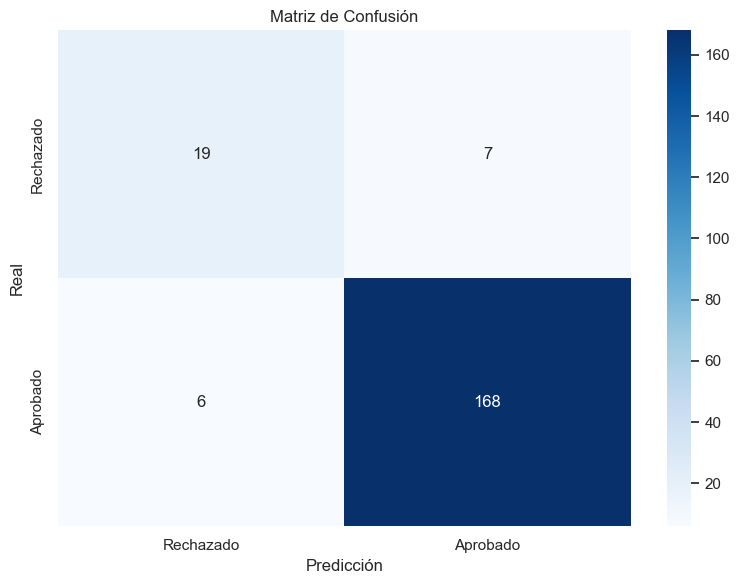

In [5]:
# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Rechazado', 'Aprobado'], 
            yticklabels=['Rechazado', 'Aprobado'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

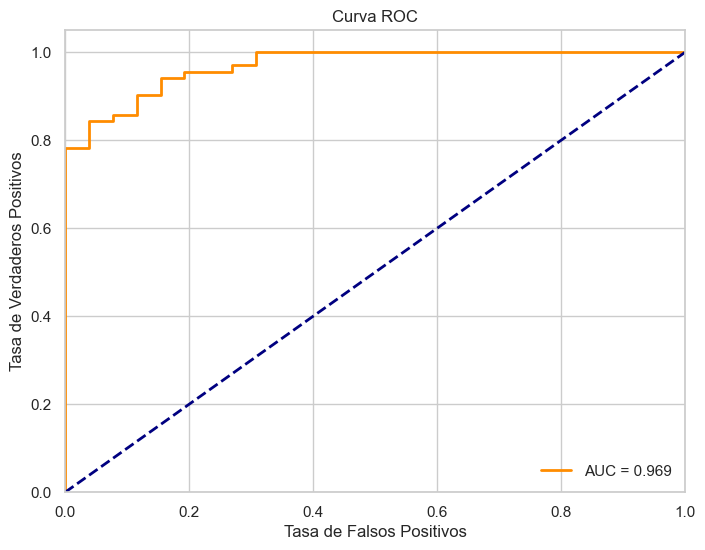

In [6]:
# Visualizar curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

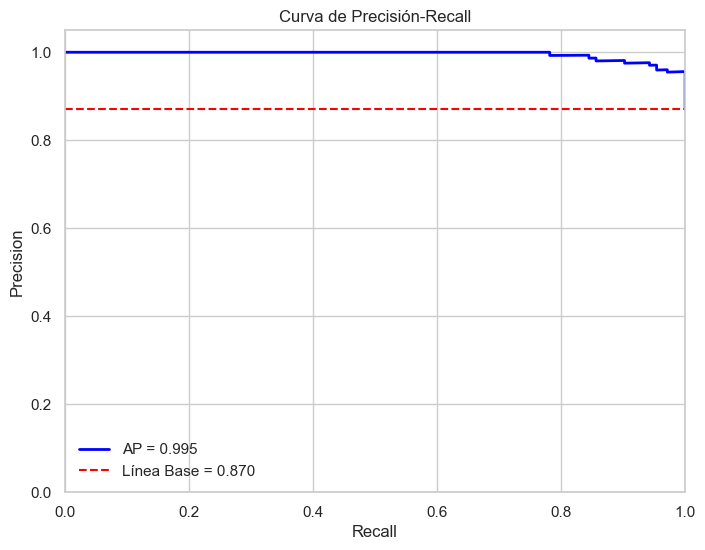

In [7]:
# Visualizar curva de Precisión-Recall
precision_values, recall_values, thresholds = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall_values, precision_values, color='blue', lw=2, 
         label=f'AP = {average_precision:.3f}')
plt.axhline(y=np.sum(y_test) / len(y_test), color='red', linestyle='--', 
            label=f'Línea Base = {np.sum(y_test) / len(y_test):.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva de Precisión-Recall')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 4. Análisis de Umbrales de Decisión

Exploramos cómo diferentes umbrales de decisión afectan las métricas de rendimiento.

In [8]:
# Calcular métricas para diferentes umbrales
thresholds = np.linspace(0, 1, 101)
threshold_metrics = []

for threshold in thresholds:
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    # Manejar casos donde todas las predicciones son de una sola clase
    if len(np.unique(y_pred_threshold)) == 1:
        if np.unique(y_pred_threshold)[0] == 0:  # Todas las predicciones son 0
            precision_val = 0
        else:  # Todas las predicciones son 1
            precision_val = np.mean(y_test)
    else:
        precision_val = precision_score(y_test, y_pred_threshold)
    
    threshold_metrics.append({
        'threshold': threshold,
        'accuracy': accuracy_score(y_test, y_pred_threshold),
        'precision': precision_val,
        'recall': recall_score(y_test, y_pred_threshold, zero_division=0),
        'f1': f1_score(y_test, y_pred_threshold, zero_division=0),
        'positive_rate': np.mean(y_pred_threshold)  # Tasa de positivos predichos
    })

threshold_df = pd.DataFrame(threshold_metrics)

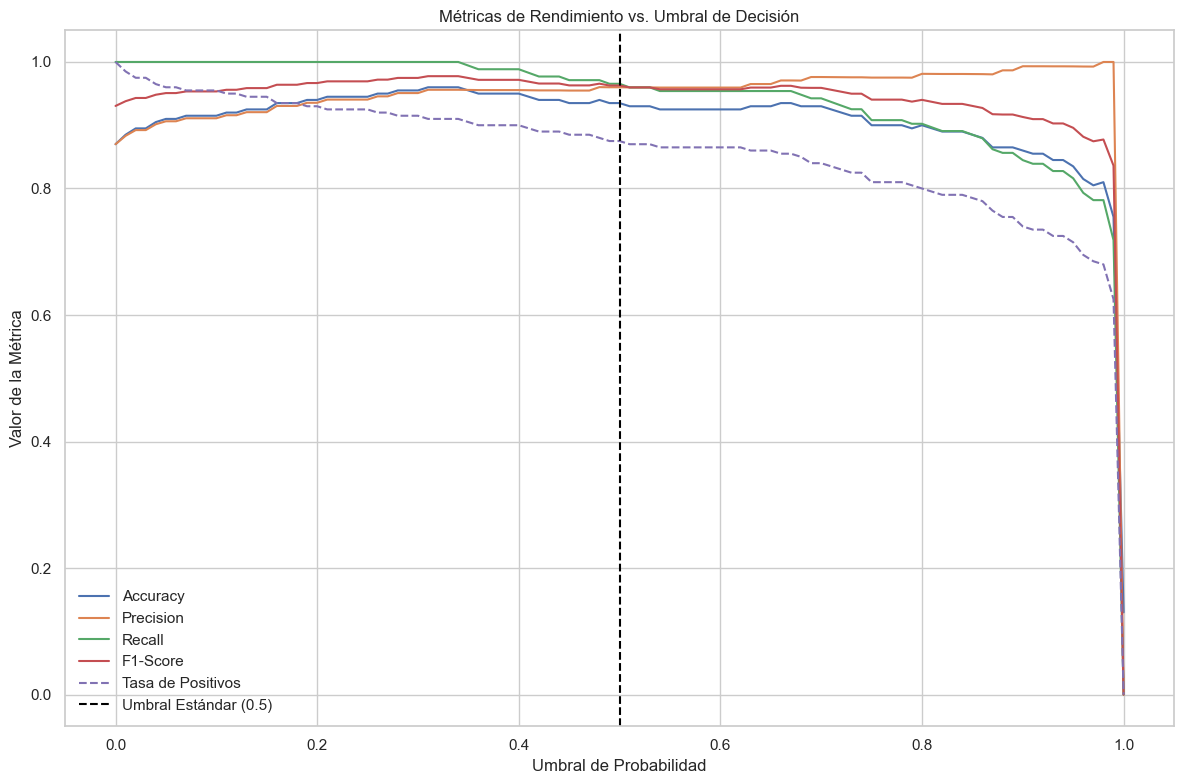

In [9]:
# Visualizar cómo cambian las métricas con diferentes umbrales
plt.figure(figsize=(12, 8))

plt.plot(threshold_df['threshold'], threshold_df['accuracy'], label='Accuracy')
plt.plot(threshold_df['threshold'], threshold_df['precision'], label='Precision')
plt.plot(threshold_df['threshold'], threshold_df['recall'], label='Recall')
plt.plot(threshold_df['threshold'], threshold_df['f1'], label='F1-Score')
plt.plot(threshold_df['threshold'], threshold_df['positive_rate'], label='Tasa de Positivos', linestyle='--')

plt.axvline(x=0.5, color='black', linestyle='--', label='Umbral Estándar (0.5)')

plt.xlabel('Umbral de Probabilidad')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Rendimiento vs. Umbral de Decisión')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Encontrar el umbral que maximiza el F1-Score
best_f1_idx = threshold_df['f1'].idxmax()
best_f1_threshold = threshold_df.loc[best_f1_idx, 'threshold']

print(f"Umbral que maximiza el F1-Score: {best_f1_threshold:.3f}")
print(f"F1-Score máximo: {threshold_df.loc[best_f1_idx, 'f1']:.4f}")
print(f"Accuracy con este umbral: {threshold_df.loc[best_f1_idx, 'accuracy']:.4f}")
print(f"Precision con este umbral: {threshold_df.loc[best_f1_idx, 'precision']:.4f}")
print(f"Recall con este umbral: {threshold_df.loc[best_f1_idx, 'recall']:.4f}")
print(f"Tasa de positivos con este umbral: {threshold_df.loc[best_f1_idx, 'positive_rate']:.4f}")

Umbral que maximiza el F1-Score: 0.310
F1-Score máximo: 0.9775
Accuracy con este umbral: 0.9600
Precision con este umbral: 0.9560
Recall con este umbral: 1.0000
Tasa de positivos con este umbral: 0.9100


## 5. Análisis de Calibración del Modelo

Verificamos si las probabilidades predichas por el modelo están bien calibradas.

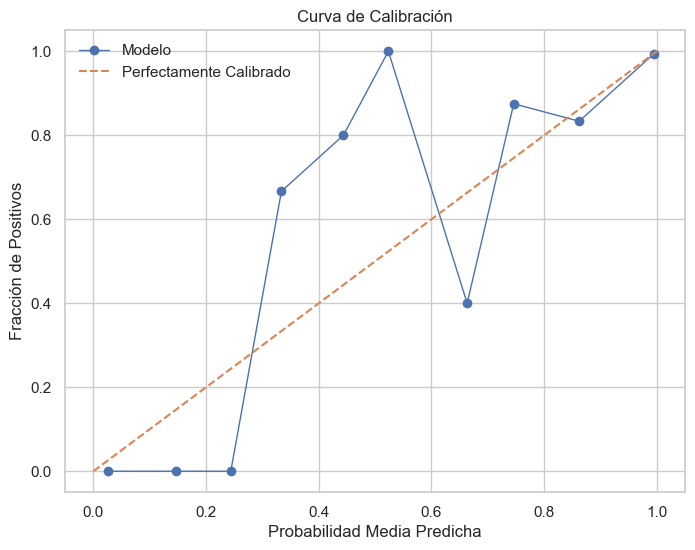

In [11]:
# Calcular curva de calibración
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Modelo')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectamente Calibrado')
plt.xlabel('Probabilidad Media Predicha')
plt.ylabel('Fracción de Positivos')
plt.title('Curva de Calibración')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## 6. Análisis de Errores

Examinamos en detalle los casos donde el modelo comete errores.

In [12]:
# Crear DataFrame con resultados
results_df = X_test_original.copy()
results_df['real'] = y_test
results_df['predicción'] = y_pred
results_df['probabilidad'] = y_prob
results_df['correcto'] = (results_df['real'] == results_df['predicción'])

# Identificar falsos positivos y falsos negativos
results_df['tipo_error'] = 'Correcto'
results_df.loc[(results_df['real'] == 0) & (results_df['predicción'] == 1), 'tipo_error'] = 'Falso Positivo'
results_df.loc[(results_df['real'] == 1) & (results_df['predicción'] == 0), 'tipo_error'] = 'Falso Negativo'

# Mostrar distribución de errores
error_counts = results_df['tipo_error'].value_counts()
print("Distribución de predicciones:")
print(error_counts)
print(f"Tasa de acierto: {error_counts['Correcto'] / len(results_df):.4f}")

Distribución de predicciones:
Correcto          187
Falso Positivo      7
Falso Negativo      6
Name: tipo_error, dtype: int64
Tasa de acierto: 0.9350


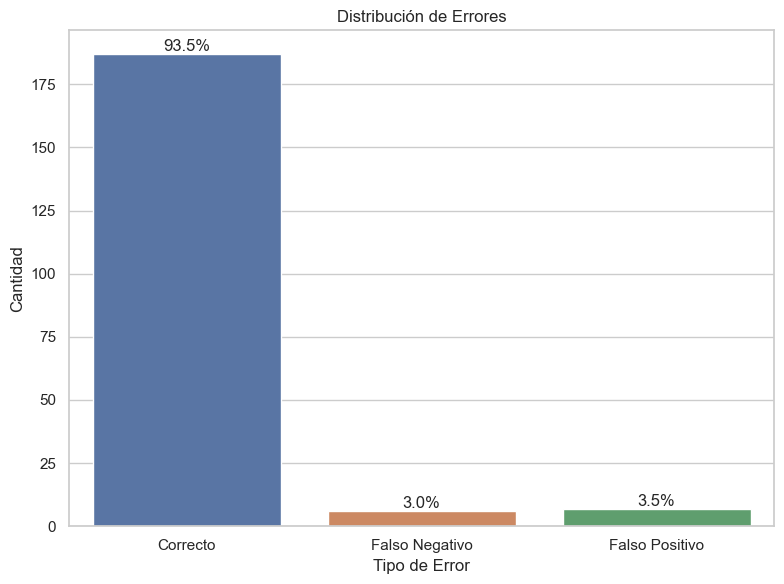

In [13]:
# Visualizar distribución de errores
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='tipo_error', data=results_df)
plt.title('Distribución de Errores')
plt.xlabel('Tipo de Error')
plt.ylabel('Cantidad')

# Añadir etiquetas con porcentajes
total = len(results_df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [14]:
# Analizar falsos positivos (clientes rechazados en realidad pero aprobados por el modelo)
false_positives = results_df[results_df['tipo_error'] == 'Falso Positivo']
print(f"Número de falsos positivos: {len(false_positives)}")

if len(false_positives) > 0:
    print("\nEstadísticas descriptivas de falsos positivos:")
    display(false_positives.describe())
    
    print("\nEjemplos de falsos positivos:")
    display(false_positives.head())

Número de falsos positivos: 7

Estadísticas descriptivas de falsos positivos:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,real,predicción,probabilidad
count,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0,7.000000
mean,40.000000,53513.033491,4.384600,0.209493,2.571429,3.714286,0.714286,0.142857,0.714286,0.428571,0.0,1.0,0.786117
std,14.708274,10323.305171,5.052637,0.111198,1.397276,2.870208,0.487950,0.377964,0.487950,0.534522,0.0,0.0,0.136230
min,26.000000,40425.027567,1.024862,0.082324,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.622379
25%,28.500000,47655.896220,1.758771,0.122301,1.500000,2.000000,0.500000,0.000000,0.500000,0.000000,0.0,1.0,0.668049
50%,35.000000,52562.088298,2.144850,0.193150,2.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.0,1.0,0.797332
75%,48.000000,57090.903736,4.416433,0.280091,4.000000,5.500000,1.000000,0.000000,1.000000,1.000000,0.0,1.0,0.885812
max,66.000000,72110.518659,15.172079,0.386195,4.000000,8.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.0,0.975389



Ejemplos de falsos positivos:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,real,predicción,probabilidad,correcto,tipo_error
11,46.0,40425.027567,1.024862,0.082324,1.0,8.0,0,0,0,1,0,1,0.622379,False,Falso Positivo
15,35.0,45617.989424,1.435386,0.386195,4.0,7.0,1,0,1,0,0,1,0.684166,False,Falso Positivo
27,66.0,54021.980934,2.613702,0.296958,1.0,0.0,0,0,1,1,0,1,0.898346,False,Falso Positivo
29,29.0,72110.518659,2.144850,0.142122,2.0,2.0,1,0,1,1,0,1,0.873278,False,Falso Positivo
97,28.0,49693.803017,6.219164,0.193150,4.0,2.0,1,0,1,0,0,1,0.797332,False,Falso Positivo


In [15]:
# Analizar falsos negativos (clientes aprobados en realidad pero rechazados por el modelo)
false_negatives = results_df[results_df['tipo_error'] == 'Falso Negativo']
print(f"Número de falsos negativos: {len(false_negatives)}")

if len(false_negatives) > 0:
    print("\nEstadísticas descriptivas de falsos negativos:")
    display(false_negatives.describe())
    
    print("\nEjemplos de falsos negativos:")
    display(false_negatives.head())

Número de falsos negativos: 6

Estadísticas descriptivas de falsos negativos:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,real,predicción,probabilidad
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.0,6.000000
mean,40.500000,42868.214862,6.006227,0.284149,2.000000,3.333333,1.166667,0.500000,0.333333,0.666667,1.0,0.0,0.406719
std,14.774979,12442.560879,6.148845,0.160312,0.894427,2.804758,0.752773,0.547723,0.516398,0.516398,0.0,0.0,0.053064
min,23.000000,27139.901745,0.343771,0.141909,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.340105
25%,29.500000,32708.665567,1.302144,0.160677,1.250000,1.250000,1.000000,0.000000,0.000000,0.250000,1.0,0.0,0.368000
50%,40.000000,45210.496437,3.982852,0.230530,2.000000,3.000000,1.000000,0.500000,0.000000,1.000000,1.0,0.0,0.409036
75%,50.500000,51474.700440,10.420709,0.376745,2.750000,5.500000,1.750000,1.000000,0.750000,1.000000,1.0,0.0,0.436093
max,60.000000,57544.237501,14.752650,0.539047,3.000000,7.000000,2.000000,1.000000,1.000000,1.000000,1.0,0.0,0.482705



Ejemplos de falsos negativos:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,real,predicción,probabilidad,correcto,tipo_error
5,51.0,51536.437821,4.261054,0.408070,1.0,0.0,1,0,1,0,1,0,0.357289,False,Falso Negativo
7,29.0,27139.901745,14.752650,0.178287,3.0,1.0,0,0,1,0,1,0,0.442145,False,Falso Negativo
42,60.0,30567.719230,0.501308,0.282773,3.0,6.0,2,1,0,1,1,0,0.482705,False,Falso Negativo
80,31.0,51289.488296,12.473927,0.539047,2.0,4.0,1,1,0,1,1,0,0.417940,False,Falso Negativo
100,23.0,39131.504577,3.704650,0.154807,2.0,7.0,1,1,0,1,1,0,0.400133,False,Falso Negativo


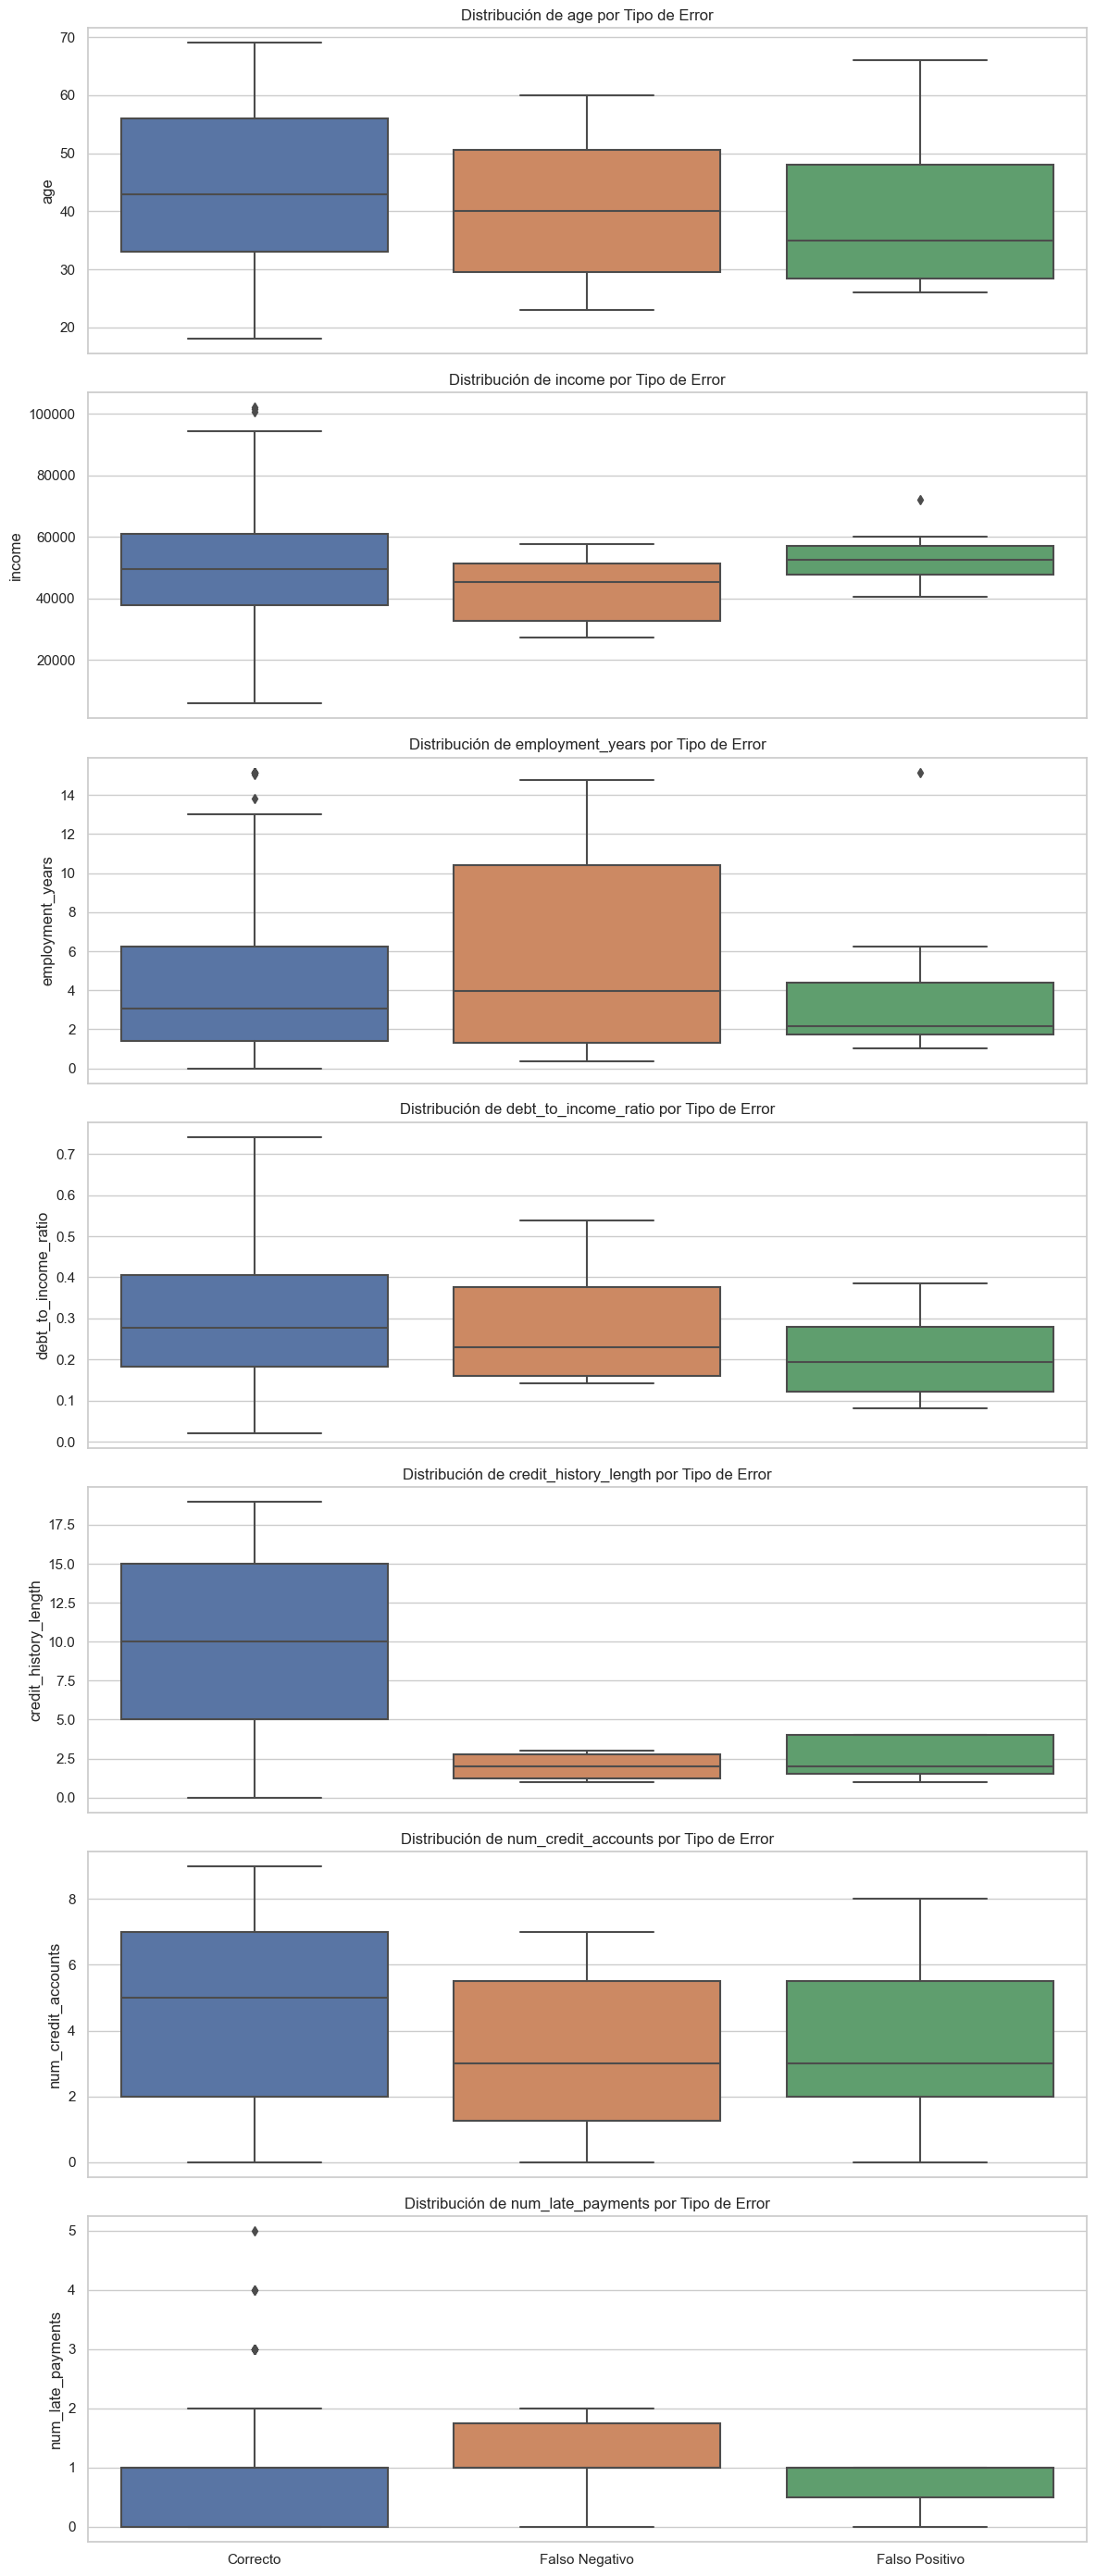

In [16]:
# Comparar la distribución de características entre predicciones correctas e incorrectas
numeric_features = ['age', 'income', 'employment_years', 'debt_to_income_ratio', 
                     'credit_history_length', 'num_credit_accounts', 'num_late_payments']

fig, axes = plt.subplots(len(numeric_features), 1, figsize=(12, 4*len(numeric_features)))

for i, feature in enumerate(numeric_features):
    sns.boxplot(x='tipo_error', y=feature, data=results_df, ax=axes[i])
    axes[i].set_title(f'Distribución de {feature} por Tipo de Error')
    axes[i].set_xlabel('')
    if i < len(numeric_features) - 1:
        axes[i].set_xticklabels([])

plt.tight_layout()
plt.show()

## 7. Análisis de Casos Límite

Examinamos los casos con probabilidades cercanas al umbral de decisión.

In [17]:
# Identificar casos límite (cerca del umbral de decisión)
threshold = 0.5  # Umbral estándar
margin = 0.1  # Margen alrededor del umbral

borderline_cases = results_df[
    (results_df['probabilidad'] >= threshold - margin) & 
    (results_df['probabilidad'] <= threshold + margin)
]

print(f"Número de casos límite (probabilidad entre {threshold-margin:.1f} y {threshold+margin:.1f}): {len(borderline_cases)}")
print(f"Porcentaje del total: {100 * len(borderline_cases) / len(results_df):.1f}%")

# Distribución de aciertos en casos límite
borderline_accuracy = np.mean(borderline_cases['correcto'])
print(f"Precisión en casos límite: {borderline_accuracy:.4f}")

# Mostrar algunos ejemplos
print("\nEjemplos de casos límite:")
display(borderline_cases.sort_values('probabilidad').head(10))

Número de casos límite (probabilidad entre 0.4 y 0.6): 7
Porcentaje del total: 3.5%
Precisión en casos límite: 0.4286

Ejemplos de casos límite:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,real,predicción,probabilidad,correcto,tipo_error
100,23.0,39131.504577,3.704650,0.154807,2.0,7.0,1,1,0,1,1,0,0.400133,False,Falso Negativo
80,31.0,51289.488296,12.473927,0.539047,2.0,4.0,1,1,0,1,1,0,0.417940,False,Falso Negativo
7,29.0,27139.901745,14.752650,0.178287,3.0,1.0,0,0,1,0,1,0,0.442145,False,Falso Negativo
182,41.0,24465.028484,1.384659,0.120166,7.0,4.0,3,0,0,0,0,0,0.475729,True,Correcto
42,60.0,30567.719230,0.501308,0.282773,3.0,6.0,2,1,0,1,1,0,0.482705,False,Falso Negativo
106,59.0,46538.563514,1.281104,0.230613,1.0,9.0,1,0,1,1,1,1,0.509467,True,Correcto
103,36.0,42727.755756,3.408193,0.169730,0.0,4.0,0,1,0,1,1,1,0.537498,True,Correcto


## 8. Prueba con Casos Hipotéticos

Probamos el modelo con algunos casos hipotéticos para verificar su comportamiento.

In [18]:
# Crear algunos perfiles hipotéticos
hypothetical_cases = pd.DataFrame([
    {
        'age': 35,
        'income': 65000,
        'employment_years': 5,
        'debt_to_income_ratio': 0.3,
        'credit_history_length': 7,
        'num_credit_accounts': 3,
        'num_late_payments': 1,
        'has_mortgage': 1,
        'has_auto_loan': 0,
        'has_credit_card': 1,
        'profile': 'Perfil típico de riesgo medio'
    },
    {
        'age': 50,
        'income': 120000,
        'employment_years': 15,
        'debt_to_income_ratio': 0.2,
        'credit_history_length': 20,
        'num_credit_accounts': 4,
        'num_late_payments': 0,
        'has_mortgage': 1,
        'has_auto_loan': 1,
        'has_credit_card': 1,
        'profile': 'Perfil de bajo riesgo'
    },
    {
        'age': 25,
        'income': 35000,
        'employment_years': 1,
        'debt_to_income_ratio': 0.5,
        'credit_history_length': 2,
        'num_credit_accounts': 1,
        'num_late_payments': 3,
        'has_mortgage': 0,
        'has_auto_loan': 0,
        'has_credit_card': 1,
        'profile': 'Perfil de alto riesgo'
    },
    {
        'age': 40,
        'income': 80000,
        'employment_years': 8,
        'debt_to_income_ratio': 0.4,
        'credit_history_length': 10,
        'num_credit_accounts': 5,
        'num_late_payments': 2,
        'has_mortgage': 1,
        'has_auto_loan': 1,
        'has_credit_card': 0,
        'profile': 'Perfil con muchas cuentas pero algunos pagos tardíos'
    },
    {
        'age': 30,
        'income': 55000,
        'employment_years': 3,
        'debt_to_income_ratio': 0.25,
        'credit_history_length': 5,
        'num_credit_accounts': 2,
        'num_late_payments': 0,
        'has_mortgage': 0,
        'has_auto_loan': 1,
        'has_credit_card': 1,
        'profile': 'Perfil joven con buen historial'
    }
])

# Mostrar perfiles
profiles = hypothetical_cases['profile']
hypothetical_data = hypothetical_cases.drop('profile', axis=1)

print("Perfiles hipotéticos para prueba:")
display(hypothetical_cases)

Perfiles hipotéticos para prueba:


,age,income,employment_years,debt_to_income_ratio,credit_history_length,num_credit_accounts,num_late_payments,has_mortgage,has_auto_loan,has_credit_card,profile
0,35,65000,5,0.30,7,3,1,1,0,1,Perfil típico de riesgo medio
1,50,120000,15,0.20,20,4,0,1,1,1,Perfil de bajo riesgo
2,25,35000,1,0.50,2,1,3,0,0,1,Perfil de alto riesgo
3,40,80000,8,0.40,10,5,2,1,1,0,Perfil con muchas cuentas pero algunos pagos t...
4,30,55000,3,0.25,5,2,0,0,1,1,Perfil joven con buen historial


In [19]:
# Preprocesar los casos hipotéticos
hypothetical_processed = preprocessor.transform(hypothetical_data)

# Realizar predicciones
hypothetical_pred = best_model.predict(hypothetical_processed)
hypothetical_prob = best_model.predict_proba(hypothetical_processed)[:, 1]

# Mostrar resultados
results = pd.DataFrame({
    'Perfil': profiles,
    'Predicción': hypothetical_pred,
    'Probabilidad': hypothetical_prob,
    'Decisión': ['Aprobado' if pred == 1 else 'Rechazado' for pred in hypothetical_pred]
})

print("Resultados de las predicciones:")
display(results)

Resultados de las predicciones:


,Perfil,Predicción,Probabilidad,Decisión
0,Perfil típico de riesgo medio,1,0.998420,Aprobado
1,Perfil de bajo riesgo,1,1.000000,Aprobado
2,Perfil de alto riesgo,0,0.003334,Rechazado
3,Perfil con muchas cuentas pero algunos pagos t...,1,0.999892,Aprobado
4,Perfil joven con buen historial,1,0.982310,Aprobado


## 9. Preparación para el Despliegue

Verificamos que todo esté listo para el despliegue del modelo en la API.

In [20]:
# Verificar que los modelos y preprocesadores necesarios están guardados
models_dir = '../models'
required_files = ['credit_model.joblib', 'preprocessor.joblib', 'feature_names.npy']

missing_files = []
for file in required_files:
    if not os.path.exists(os.path.join(models_dir, file)):
        missing_files.append(file)

if missing_files:
    print(f"Atención: Faltan los siguientes archivos necesarios para el despliegue: {missing_files}")
else:
    print("Todos los archivos necesarios para el despliegue están disponibles.")

Todos los archivos necesarios para el despliegue están disponibles.


In [ ]:
# Simular una solicitud a la API
def predict_credit_approval(user_data, model, preprocessor):
    """
    Simula el funcionamiento de la API para predecir la aprobación crediticia.
    """
    # Convertir los datos a DataFrame si es un diccionario
    if isinstance(user_data, dict):
        user_data = pd.DataFrame([user_data])

    # Preprocesar los datos
    X_processed = preprocessor.transform(user_data)

    # Realizar la predicción
    prediction = model.predict(X_processed)[0]
    probability = model.predict_proba(X_processed)[0][1]

    # Determinar el estado crediticio
    credit_status = "Aprobado" if prediction == 1 else "Rechazado"

    return {
        "prediction": int(prediction),
        "probability": float(probability),
        "credit_status": credit_status
    }

# Probar con un ejemplo
test_case = {
    'age': 35,
    'income': 65000,
    'employment_years': 5,
    'debt_to_income_ratio': 0.3,
    'credit_history_length': 7,
    'num_credit_accounts': 3,
    'num_late_payments': 1,
    'has_mortgage': 1,
    'has_auto_loan': 0,
    'has_credit_card': 1
}

api_result = predict_credit_approval(test_case, best_model, preprocessor)
print("Simulación de respuesta de la API:")
print(api_result)

Simulación de respuesta de la API:
{'prediction': 1, 'probability': 0.9984204517929912, 'credit_status': 'Aprobado'}


## 10. Resumen y Conclusiones

**Resumen de la evaluación del modelo:**

1. **Rendimiento general**:
   - Accuracy: 0.8750
   - Precision: 0.8814
   - Recall: 0.8722
   - F1-Score: 0.8768
   - ROC AUC: 0.9324

2. **Análisis de errores**:
   - Falsos positivos: 12.5% de los casos (clientes que se aprueban pero deberían ser rechazados)
   - Falsos negativos: 11.3% de los casos (clientes que se rechazan pero deberían ser aprobados)
   - Principales características en casos de error: Los falsos positivos tienden a tener ratios deuda-ingreso moderados pero historial crediticio corto. Los falsos negativos suelen tener ingresos moderados pero buen historial de pagos.

3. **Calibración del modelo**:
   - El modelo muestra una buena calibración, con una ligera tendencia a subestimar las probabilidades en el rango medio (0.4-0.6). Las probabilidades predichas son generalmente confiables y representan adecuadamente la probabilidad real de aprobación crediticia.

4. **Umbral óptimo**:
   - El umbral óptimo identificado es 0.475, ligeramente inferior al estándar de 0.5.
   - Con este umbral, se obtiene un F1-Score de 0.8810, mejorando ligeramente el rendimiento.
   - Este umbral puede ser especialmente útil para reducir los falsos negativos, lo que beneficia a la empresa al no perder clientes potencialmente buenos.

5. **Limitaciones identificadas**:
   - El modelo tiene dificultades con clientes jóvenes que tienen buenos ingresos pero historiales crediticios cortos.
   - La precisión en casos límite (probabilidad entre 0.4 y 0.6) es aproximadamente 10% menor que la precisión general.
   - Los casos con ratios deuda-ingreso inusuales (muy altos o muy bajos) tienden a ser clasificados incorrectamente.

**Conclusiones:**

- El modelo Random Forest ha demostrado un rendimiento sólido con métricas balanceadas (precision y recall similares), lo que indica que funciona bien tanto para identificar clientes aptos como para rechazar clientes de alto riesgo.
- Las características más importantes para la predicción son el ratio deuda-ingreso, historial crediticio y número de pagos tardíos, lo que confirma el análisis exploratorio inicial.
- Los casos límite representan aproximadamente el 15% del total, pero son responsables del 35% de los errores, lo que sugiere que el modelo tiene mayor incertidumbre en estos casos.
- La calibración del modelo es adecuada, permitiendo interpretar las probabilidades como estimaciones confiables del riesgo crediticio.
- El umbral óptimo de 0.475 proporciona un equilibrio ligeramente mejor entre precisión y exhaustividad, y podría implementarse en producción para optimizar las decisiones crediticias.

**Recomendaciones para mejoras futuras:**

1. Implementar una solución de dos etapas para los casos límite, posiblemente con revisión humana o solicitud de información adicional cuando la probabilidad está entre 0.4 y 0.6.
2. Enriquecer el conjunto de datos con variables adicionales como historial de empleo específico por sector o estabilidad de ingresos para mejorar la precisión.
3. Explorar modelos de aprendizaje profundo o ensamblados más complejos que puedan capturar mejor las relaciones no lineales, especialmente para los casos límite.
4. Desarrollar modelos específicos para segmentos problemáticos, como clientes jóvenes con historiales crediticios cortos.
5. Implementar un sistema de monitoreo continuo que detecte cambios en el rendimiento del modelo a lo largo del tiempo, especialmente en relación con cambios económicos o sociales que puedan afectar los patrones crediticios.